# Lesson: Model Learning

## Introduction

### Learning Outcomes

By the end of this lesson, you will be able to:

- Create a model/method that includes and excludes features.
- Generate derived features.
- Hyperparameter models/methods learn how to learn.
- Parameters -> cross-validation -> best parameters.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

penguins_df = pd.read_csv("../data/penguins_clean.csv")
penguins_df = penguins_df.dropna()
penguins_df["sex"] = penguins_df["sex"].map({"male": True, "female": False})
penguins_df = pd.get_dummies(penguins_df, drop_first=True)

target = penguins_df.pop("body_mass_g")
penguins_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bill_length_mm     333 non-null    float64
 1   bill_depth_mm      333 non-null    float64
 2   flipper_length_mm  333 non-null    float64
 3   sex                333 non-null    bool   
 4   year               333 non-null    int64  
 5   species_Chinstrap  333 non-null    bool   
 6   species_Gentoo     333 non-null    bool   
 7   island_Dream       333 non-null    bool   
 8   island_Torgersen   333 non-null    bool   
dtypes: bool(5), float64(3), int64(1)
memory usage: 14.6 KB


## Features

### Feature Importance

Some features have little or no predictive power.

In small datasets, there is a signal and noise. With our penguin dataset, we add a "toy" feature based on eye color. If eye color correlates to island, it is likely noise. If eye color correlates to species, it is likely a signal. A model shouldn't be perfect.

With absolutely huge datasets, computational efficiency is a concern (though larger companies use it). If a useless feature doesn't work, it will slow down the training process. Algorithms differ in how they scale. Useless features can only hurt, never help.

With clients, keep the business need in mind. When we have a linear model that predicts an R<sup>2</sup> of 0.65, that can be efficient. It's fast, simple, and easy to interpret. When we have a neural network that predicts an R<sup>2</sup> of 0.73, that may not be as efficient. The computation takes up a lot of time and can't be explained. There are trade-offs: "Good, fast, cheap. Pick two."

### There are three feature elimination techniques.

#### 1. Manual

Play around with our dataset. Noodle. If we eliminate 1-n features, we have an intuition, we have a hunch.

The methods and models learn for us, but we need to be curious and have a spark.

#### 2. Wrapper Classes and Methods

There are a crazy amount of [feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) (or feature elimination) classes and methods.

**To Remove**

- low variance features
- a univariate (single variable) feature
- recursive features
- l1: adds the absolute value of the coefficients as a penalty term
- l2: adds the squared value of the coefficients as a penalty term
- tree-based features
- sequential features

and on and on...

In [13]:
# Remove low variance features
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.25)
selector.fit(penguins_df)
features = penguins_df.columns[selector.get_support(indices=True)]
print(f"Selected features: {features}")

Selected features: Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'year'], dtype='object')


In [14]:
# Recursive feature elimination
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

model = LinearRegression()
rfe = RFE(model)  # half of features remain
fit = rfe.fit(penguins_df, target)
print(f"Num Features: {fit.n_features_}")
print(f"Selected Features: {penguins_df.columns[fit.support_]}")
print(f"Ranking Features: {fit.ranking_}")

Num Features: 4
Selected Features: Index(['bill_depth_mm', 'sex', 'species_Chinstrap', 'species_Gentoo'], dtype='object')
Ranking Features: [2 1 6 1 5 1 1 3 4]


#### 3. Models/Algorithms

There are models that come "pre-baked" with feature elimination. They can be linear models, tree-based models, or high-dimensional models.

In [15]:
# L1: adds the absolute value of the coefficients as a penalty term
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=5.0)
lasso.fit(penguins_df, target)
print(f"Lasso Coefficients: {lasso.coef_}")
print(f"Selected Features: {penguins_df.columns[lasso.coef_ != 0]}")

Lasso Coefficients: [  19.30719882   29.93001194   23.61510437  369.60856954  -48.18746954
 -283.67364291  658.49532775   -0.           -1.35366185]
Selected Features: Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'sex', 'year',
       'species_Chinstrap', 'species_Gentoo', 'island_Torgersen'],
      dtype='object')


In [16]:
# Tree-based feature selection
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=4)
dt.fit(penguins_df, target)
print(dt.feature_importances_)
print(f"Selected Features: {penguins_df.columns[dt.feature_importances_ != 0]}")

[0.01442772 0.01030911 0.02368183 0.19728404 0.         0.
 0.7542973  0.         0.        ]
Selected Features: Index(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'sex',
       'species_Gentoo'],
      dtype='object')


### Derived Features

Features that expand, alter, or reduce features that already exist in our dataset. It requires a lot of domain knowledge. We have to have an intuition.

In [The Minnesota Twin Family Study (MTFS)](https://mctfr.psych.umn.edu/our-research/twin-family-study), we have derived features:

- summary scores from interviews and/or questionnaires
- latent factors (factor analysis, PCA) capturing broad behavioral constructs
- use a cognitive score after controlling for age

There are also derived features in the census data.

- Ages: 0-5, 18-25, etc
- Urban versus rural
- Income aggregation
- Socioeconomic status

Our penguins species and island data has derived features.

In [17]:
penguins_df[
    [
        col
        for col in penguins_df.columns
        if col.startswith("island_") or col.startswith("species_")
    ]
].head()

,species_Chinstrap,species_Gentoo,island_Dream,island_Torgersen
0,False,False,False,True
1,False,False,False,True
2,False,False,False,True
4,False,False,False,True
5,False,False,False,True


### Hyperparameters

Parameters (features, independent variables, etc) are part of our model. Hyperparameter models learn how to learn. When we configure the model's structure, there are hyperparameters that aren't directly part of our dataset.

Parameters learn, hyperparameters are chosen.

Our linear regression model doesn't use hyperparameters, but LASSO does.

The Ridge model uses `l2`, squared value of the coefficients as a penalty term. That's a hyperparameter.

There are various other models:
- Grid search
- Random search
- Bayesian optimization
- Gradient-based optimization
- Evolutionary optimization
- Population-based training (PBT)

There are an abundance of models. We'll just keep it simple.

### Cross-validation

A resampling technique that "mixes up" our testing and training data. There are various iterations. 

There are models that use the `cv` argument, which default to `None`.

- `RidgeCV`: use the efficient Leave-One-Out cross-validation
- `LassoCV`: use the default 5-fold cross-validation
- `GridSearchCV`: use the default 5-fold cross-validation

A model's performance includes variety. Cross-validation has a lot of variety.

![Cross-validation](../assets/cross-validation.png)

Cross-validation does **not** include:
- human biases
- time-series
- spatial dimensions (geography, 3 dimensions)

### Models and Visualizations

LassoCV Coefficients: [  23.36834117    0.           26.9677476   360.45186878  -52.7838009
 -287.52833906  416.78407772   -0.           -0.        ]
R^2 Score: 0.8677175721631945
Removed Features: 3
Selected Features: Index(['bill_length_mm', 'flipper_length_mm', 'sex', 'year',
       'species_Chinstrap', 'species_Gentoo'],
      dtype='object')


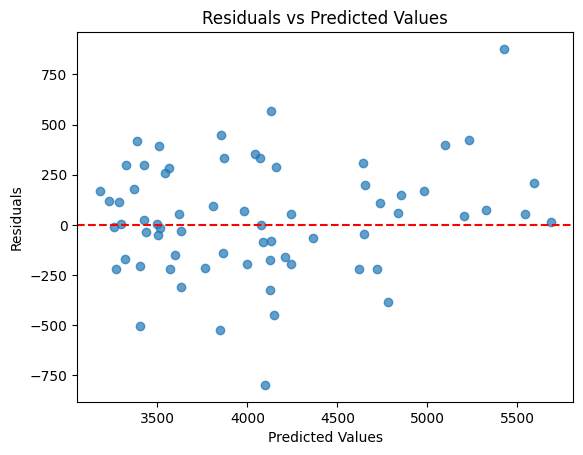

In [18]:
# LassoCV - least absolute shrinkage and selection operator with cross-validation
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    penguins_df, target, test_size=0.2, random_state=42
)

lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)
print(f"LassoCV Coefficients: {lasso.coef_}")
print(f"R^2 Score: {lasso.score(X_test, y_test)}")
print(f"Removed Features: {(lasso.coef_ == 0).sum()}")
print(f"Selected Features: {X_train.columns[lasso.coef_ != 0]}")

y_pred = lasso.predict(X_test)
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

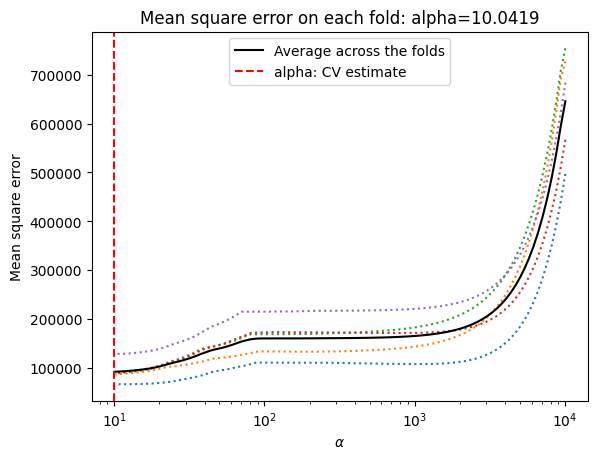

In [19]:
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=1.5,
)
plt.axvline(lasso.alpha_, linestyle="--", color="red", label="alpha: CV estimate")

plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title(f"Mean square error on each fold: alpha={lasso.alpha_:.4f}")
plt.show()

RidgeCV Coefficients: [  25.02828896   44.51026837   20.05170103  369.66313666  -50.18467118
 -330.24267511  725.03614991  -17.71358353  -84.12141881]
R^2 Score: 0.8744289842789292


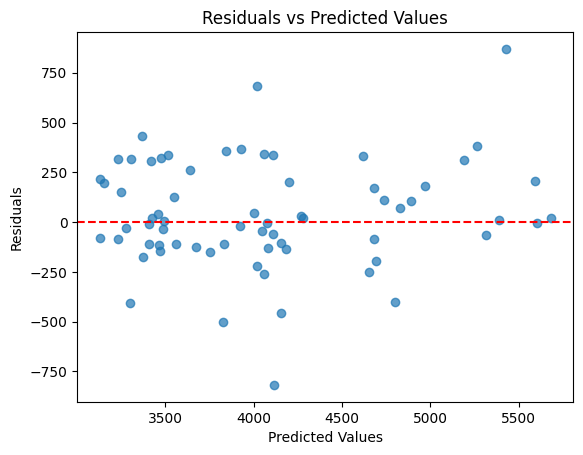

In [20]:
# RidgeCV - least squares with L2 regularization and cross-validation
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(cv=5)
ridge.fit(X_train, y_train)
print(f"RidgeCV Coefficients: {ridge.coef_}")
print(f"R^2 Score: {ridge.score(X_test, y_test)}")

y_pred = ridge.predict(X_test)
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()

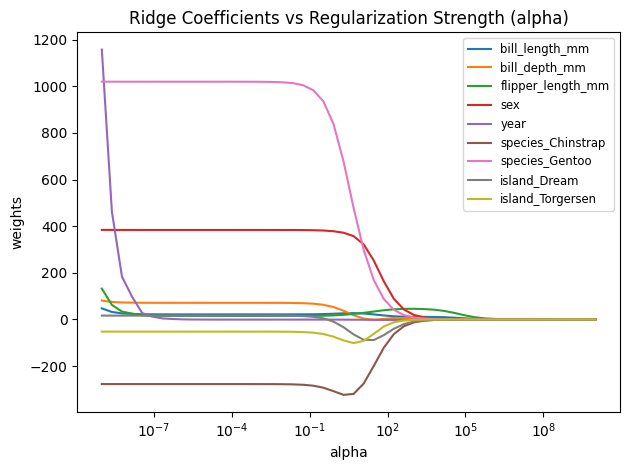

In [32]:
n = 50
alphas = np.logspace(-9, 10, n)
coefs = []
for a in alphas:
    ridge = RidgeCV(alphas=[a], fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge Coefficients vs Regularization Strength (alpha)")
plt.tight_layout()
plt.legend([f"{col}" for col in X_train.columns], fontsize="small")
plt.show()

Best Parameters: {'alpha': 1.0, 'max_iter': 1000}
R^2 Score: 0.8743875955403452


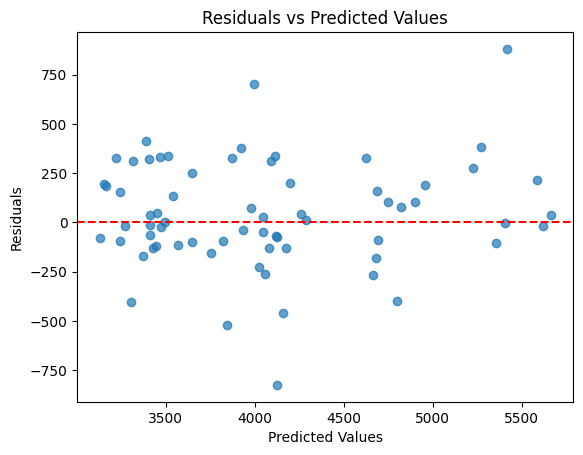

In [22]:
# GridSearchCV using Lasso
# Lasso has alpha and max_iter arguments
from sklearn.model_selection import GridSearchCV

params = {
    "alpha": [0.1, 1.0, 10.0, 50.0],
    "max_iter": [1000, 5000, 10000],
}

grid_search = GridSearchCV(Lasso(), params, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

print(f"R^2 Score: {best_model.score(X_test, y_test)}")

y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()